In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string 
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import json
import vincent
import branca.colormap as cm

In [12]:
LSOA_main = gpd.read_file('map_data/LSOA/LSOA.shp')
LSOA_main = LSOA_main.to_crs(epsg=4326)

#Create District Names
LSOA_main['District'] = LSOA_main.lsoa11nm.apply(lambda x: ' '.join(x.split(' ')[:-1]))                                    
                                                                    
#Import some data about London only LSOAs and extract districts from them
Lon_LSOAs = pd.read_csv('map_data/LSOA/LSOA_London.csv')

In [9]:
London_districts = set(Lon_LSOAs.LAD11NM)
#Filter on London Districts
len(LSOA_main[LSOA_main.District.apply(lambda x: x in London_districts)])


London_LSOAs = set(Lon_LSOAs['Lower Super Output Area'])
LSOA_main = LSOA_main[LSOA_main.lsoa11cd.apply(lambda x: x in London_LSOAs)]

In [10]:
LSOA_shape = LSOA_main

choropleth_json = gpd.GeoDataFrame(LSOA_shape).to_json()
Choro_dict = LSOA_shape[['objectid', 'st_lengths']].set_index('objectid')['st_lengths']

In [5]:
linear = cm.LinearColormap(['red','black','blue'], 
                           vmin=LSOA_shape['st_lengths'].quantile(.1),
                           vmax=LSOA_shape['st_lengths'].quantile(.9))

linear.caption = 'st_lengths'

choropleths = folium.GeoJson(
        json.loads(choropleth_json),
        smooth_factor = 1.0,
        style_function=lambda feature: 
        {
        'fillColor': linear(Choro_dict[feature['properties']['objectid']]),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5'
        },
        )

In [15]:
m = folium.Map(location=[51.507, -0.128], tiles='Stamen Toner', zoom_start=12)

m.add_child(linear)
m.add_child(choropleths)

m.save('visualisations/London_LSOAs.html')

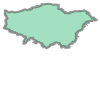

In [7]:
from shapely.ops import cascaded_union
polygons = list(LSOA_shape.geometry)
boundary = gpd.GeoSeries(cascaded_union(polygons))
boundary[0]

In [18]:
#Save down cleaned LSOAs
LSOA_shape.to_file(filename= 'map_data/LSOA/London_LSOA_shape_cleaned.shp', driver='GeoJSON', encoding='utf-8') 